In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch

from einops import rearrange
from importlib import import_module
from tqdm import tqdm

from skp.toolbox.classes import Ensemble
from skp.toolbox.functions import load_kfold_ensemble_as_list

In [4]:
def run_model(model, x, img_shape):
    with torch.inference_mode():
        mask = model({"x": x})
        mask = torch.nn.functional.interpolate(mask, size=img_shape, mode="bilinear")
        mask = mask[0].cpu().numpy()
    return mask

In [2]:
cfg = import_module("skp.configs.lines_and_tubes.cfg_seg_single_line").cfg 
cfg.pretrained = False
cfg.load_pretrained_model = None
cvc_model_list = load_kfold_ensemble_as_list(
    cfg, 
    weights_paths=[cfg.save_dir + f"lines_and_tubes.cfg_seg_single_line/cvc_only/fold{fold}/checkpoints/last.ckpt" for fold in range(5)], 
    device="cuda", 
    eval_mode=True
)

ngt_model_list = load_kfold_ensemble_as_list(
    cfg, 
    weights_paths=[cfg.save_dir + f"lines_and_tubes.cfg_seg_single_line/ngt_only/fold{fold}/checkpoints/last.ckpt" for fold in range(5)], 
    device="cuda", 
    eval_mode=True
)

ett_model_list = load_kfold_ensemble_as_list(
    cfg, 
    weights_paths=[cfg.save_dir + f"lines_and_tubes.cfg_seg_single_line/ett_only/fold{fold}/checkpoints/last.ckpt" for fold in range(5)], 
    device="cuda", 
    eval_mode=True
)

swan_model_list = load_kfold_ensemble_as_list(
    cfg, 
    weights_paths=[cfg.save_dir + f"lines_and_tubes.cfg_seg_single_line/swan_only/fold{fold}/checkpoints/last.ckpt" for fold in range(5)], 
    device="cuda", 
    eval_mode=True
)

cvc_model = Ensemble(cvc_model_list, activation_fn="sigmoid")
ngt_model = Ensemble(ngt_model_list, activation_fn="sigmoid")
ett_model = Ensemble(ett_model_list, activation_fn="sigmoid")
swan_model = Ensemble(swan_model_list, activation_fn="sigmoid")

/home/ian/miniconda3/envs/skp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ian/miniconda3/envs/skp/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.23). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [11]:
ROOT = "/mnt/stor/datasets/kaggle/ranzcr-clip-catheter-line-classification"

In [12]:
df = pd.read_csv(os.path.join(ROOT, "train_kfold_cv.csv"))
df_anno = pd.read_csv(os.path.join(ROOT, "train_annotations.csv"))
df_no_anno = df.loc[~df.StudyInstanceUID.isin(df_anno.StudyInstanceUID.tolist())]
df_no_anno

,StudyInstanceUID,ett_abnormal,ett_borderline,ett_normal,ngt_abnormal,ngt_borderline,ngt_incompletelyimaged,ngt_normal,cvc_abnormal,cvc_borderline,...,inner0,inner1,inner2,inner3,inner4,fold,mask_present,sampling_weight_log,sampling_weight_inv,sampling_weight_max_ent
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,...,2,4,2,-1,1,3,0,10.629426,28.410370,20.329617
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,...,1,0,4,-1,3,3,0,6.953356,7.917836,6.437924
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,...,-1,2,4,1,2,0,0,6.426200,6.592300,5.459253
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,...,4,-1,3,1,1,1,0,1.000000,1.000000,1.000000
5,1.2.826.0.1.3680043.8.498.11707076266253086830...,0,0,1,0,0,0,1,0,0,...,-1,4,3,1,4,0,0,5.278432,4.423760,3.812522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27139,1.2.826.0.1.3680043.8.498.12112840402677606176...,0,0,0,0,0,0,0,0,1,...,2,3,2,-1,4,3,0,3.649097,2.511065,2.290193
27140,1.2.826.0.1.3680043.8.498.59704742952729813362...,0,0,0,0,0,0,0,1,0,...,4,2,4,-1,2,3,0,6.426200,6.592300,5.459253
27141,1.2.826.0.1.3680043.8.498.97304417279653947772...,0,0,0,0,0,0,0,0,1,...,0,-1,2,4,1,1,0,3.649097,2.511065,2.290193
27142,1.2.826.0.1.3680043.8.498.74257566841157531124...,0,0,1,0,0,0,0,0,1,...,2,-1,4,0,3,1,0,4.139599,2.977795,2.669963


In [13]:
save_dir = os.path.join(ROOT, "masks-pseudo")
os.makedirs(save_dir, exist_ok=True)

In [18]:
label_cols = [c for c in df_no_anno.columns if c.startswith("cvc_") or c.startswith("ngt_") or c.startswith("ett_") or c.startswith("swan_")]
for row_idx, row in tqdm(df_no_anno.iterrows(), total=len(df_no_anno)):
    img0 = cv2.imread(os.path.join("/mnt/stor/datasets/kaggle/ranzcr-clip-catheter-line-classification/train", f"{row.StudyInstanceUID}.jpg"), 0)
    img = rearrange(img0, "h w -> h w 1")
    img = cfg.val_transforms(image=img)["image"]
    img = rearrange(img, "h w c -> 1 c h w")
    img = torch.from_numpy(img).float().cuda()
    mask = np.zeros(img0.shape + (4,), dtype=np.uint8)
    if row.cvc_present:
        cvc_mask = run_model(cvc_model, img, img0.shape)
        mask[:, :, 0] = (cvc_mask >= 0.5).astype("int")
    if row.ngt_present:
        ngt_mask = run_model(ngt_model, img, img0.shape)
        mask[:, :, 1] = (ngt_mask >= 0.45).astype("int")
    if row.ett_present:
        ett_mask = run_model(ett_model, img, img0.shape)
        mask[:, :, 2] = (ett_mask >= 0.4).astype("int")
    if row.swan_ganz_present:
        swan_mask = run_model(swan_model, img, img0.shape)
        mask[:, :, 3] = (swan_mask >= 0.35).astype("int")
    cv2.imwrite(os.path.join(save_dir, f"{row.StudyInstanceUID}.png"), mask)

100%|██████████| 18887/18887 [3:16:21<00:00,  1.60it/s]  


In [19]:
save_dir = os.path.join(ROOT, "masks-pseudo-soft")
os.makedirs(save_dir, exist_ok=True)

for row_idx, row in tqdm(df_no_anno.iterrows(), total=len(df_no_anno)):
    img0 = cv2.imread(os.path.join("/mnt/stor/datasets/kaggle/ranzcr-clip-catheter-line-classification/train", f"{row.StudyInstanceUID}.jpg"), 0)
    img = rearrange(img0, "h w -> h w 1")
    img = cfg.val_transforms(image=img)["image"]
    img = rearrange(img, "h w c -> 1 c h w")
    img = torch.from_numpy(img).float().cuda()
    mask = np.zeros(img0.shape + (4,), dtype=np.uint8)
    if row.cvc_present:
        cvc_mask = run_model(cvc_model, img, img0.shape)
        mask[:, :, 0] = np.round(cvc_mask * 255).astype("uint8")
    if row.ngt_present:
        ngt_mask = run_model(ngt_model, img, img0.shape)
        mask[:, :, 1] = np.round(ngt_mask * 255).astype("uint8")
    if row.ett_present:
        ett_mask = run_model(ett_model, img, img0.shape)
        mask[:, :, 2] = np.round(ett_mask * 255).astype("uint8")
    if row.swan_ganz_present:
        swan_mask = run_model(swan_model, img, img0.shape)
        mask[:, :, 3] = np.round(swan_mask * 255).astype("uint8")
    cv2.imwrite(os.path.join(save_dir, f"{row.StudyInstanceUID}.png"), mask)

100%|██████████| 18887/18887 [3:17:34<00:00,  1.59it/s]  


In [17]:
np.unique(mask), np.sum(mask, axis=(0, 1))

(array([0, 1], dtype=uint8), array([    0, 56457,     0,     0], dtype=uint64))

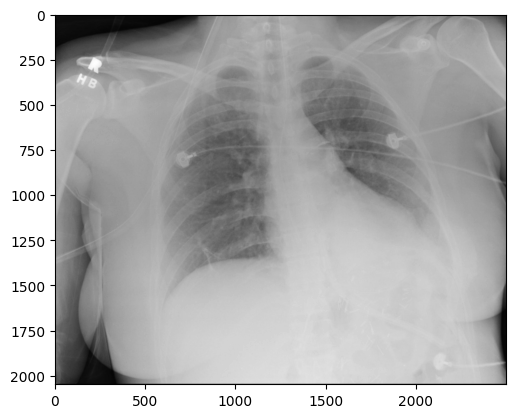

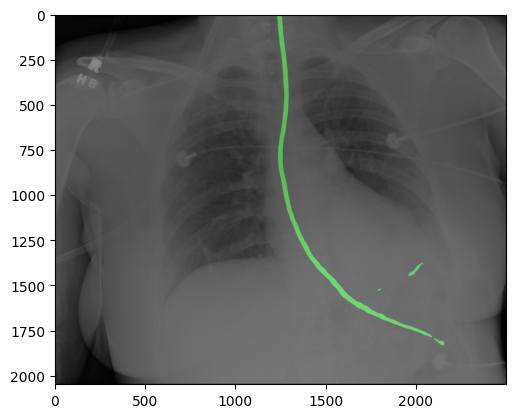

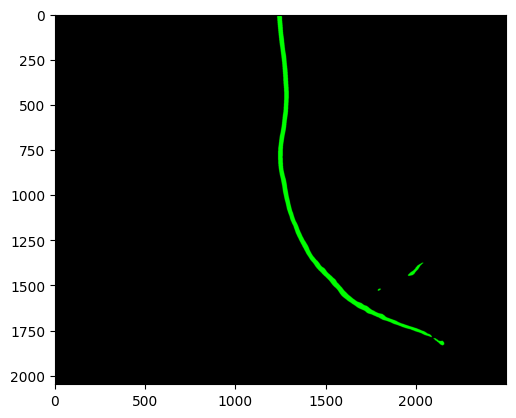

In [15]:
mask_plot = mask[..., :3] * 255

plt.imshow(img0, cmap="gray")
plt.show() 

overlay = 0.6 * cv2.cvtColor(img0, cv2.COLOR_GRAY2RGB) + 0.4 * mask_plot
overlay = overlay.astype("uint8")
plt.imshow(overlay, cmap="gray")
plt.show()

plt.imshow(mask_plot)
plt.show()